In [ ]:
!pip install gymnasium[atari] --quiet
!pip install gymnasium --quiet
!pip install -U gymnasium[atari] --quiet
!pip install imageio_ffmpeg --quiet
!pip install npy_append_array --quiet
!pip install pyTelegramBotAPI --quiet
!pip install gymnasium[accept-rom-license] --quiet
!pip install gymnasium[box2d] --quiet

In [54]:
import numpy as np 

class ExperienceReplayBuffer: 
    def __init__(self, max_memory, input_shape, batch_size, cer=False): 
        self.mem_size = max_memory
        self.mem_counter = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                     dtype=np.float32)
        self.next_state_memory = np.zeros((self.mem_size, *input_shape),
                                         dtype=np.float32)

        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)
        self.batch_size = batch_size
        self.cer = cer

    def store_experience(self, state, action, reward, next_state, done): 
        index = self.mem_counter % self.mem_size 

        self.state_memory[index] = state
        self.next_state_memory[index] = next_state
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        self.mem_counter += 1

    def sample_experience(self, batch_size):
        # used to get the last transition
        offset = 1 if self.cer else 0

        max_mem = min(self.mem_counter, self.mem_size) - offset
        batch_index = np.random.choice(max_mem, batch_size - offset, replace=False)

        states = self.state_memory[batch_index]
        next_states = self.next_state_memory[batch_index]
        rewards = self.reward_memory[batch_index]
        actions = self.action_memory[batch_index]
        terminals = self.terminal_memory[batch_index]

        if self.cer: 
            last_index = self.mem_counter % self.mem_size - 1
            last_state = self.state_memory[last_index]
            last_action = self.action_memory[last_index]
            last_terminal = self.terminal_memory[last_index]
            last_next_state = self.next_state_memory[last_index]
            last_reward = self.reward_memory[last_index]

            # for 2d and 3d use vstack to append, for 1d array use append() to append the data
            states = np.vstack((self.state_memory[batch_index], last_state))
            next_states = np.vstack((self.next_state_memory[batch_index], last_next_state))

            actions = np.append(actions, last_action)
            terminals = np.append(terminals, last_terminal)
            rewards = np.append(rewards, last_reward)
    
        return states, actions, rewards, next_states, terminals
    
    
    def is_sufficient(self): 
        return self.mem_counter > self.batch_size
        

In [23]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D, Input


class DeepQNetwork2D(keras.Model):

    def __init__(self, input_dims, n_actions):
        super(DeepQNetwork2D, self).__init__()
     #   self.fc1 = Dense(64, activation='relu')
        self.fc1 = Dense(64, activation='relu')
        self.fc2 = Dense(64, activation='relu')
        self.fc3 = Dense(n_actions, activation=None)

    def call(self, state):

        x = self.fc1(state)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


class DeepQNetwork3D(keras.Model): 
    
    def __init__(self, input_dims, n_actions):
        super(DeepQNetwork3D, self).__init__()

        self.conv1 = Conv2D(32, 8, strides=(4, 4), activation='relu', data_format="channels_first")
        self.conv2 = Conv2D(32, 4, strides=(2, 2), activation='relu', data_format="channels_first")
        self.conv3 = Conv2D(64, 3, strides=(1, 1), activation='relu', data_format="channels_first")
        self.flatten = Flatten()

        self.fc2 = Dense(128, activation='relu')
        self.fc3 = Dense(n_actions, activation=None)

    def call(self, state):

        x = self.conv1(state)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [3]:
import numpy as np

def epsilon_greedy_policy(q_val_network, observation, action_space, epsilon):
        if np.random.random() > epsilon:
            state = tf.convert_to_tensor([observation])
            actions = q_val_network.predict(state, verbose=0)
            action = tf.math.argmax(actions, axis=1).numpy()[0]
        else:
            action = np.random.choice(action_space)
        return action


def greedy_policy(observation, q_val_network, action_space): 
    state = tf.convert_to_tensor([observation])
    actions = q_val_network(state)
    action = tf.math.argmax(actions, axis=1).numpy()[0]
    return action


In [55]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam

#https://github.com/philtabor/Deep-Q-Learning-Paper-To-Code/blob/master/DQN/tf2/agent.py
class Agent: 
    def __init__(self, agent_params):
        # Parameters
        self.gamma = agent_params.get("gamma")
        self.lr = agent_params.get("lr")
        self.input_dims = agent_params.get("input_dims")
        self.batch_size = agent_params.get("batch_size")
        self.replace_target_weight_counter = agent_params.get("replace")
        self.algo = agent_params.get("algo")
        self.env_name = agent_params.get("env_name")
        self.chkpt_dir = agent_params.get("chkpt_dir")
        self.n_actions = agent_params.get("n_actions")
        self.action_space = agent_params.get('actions')
        
        self.eps = agent_params.get("eps")
        self.min_eps = agent_params.get("min_eps")
        self.eps_decay_rate = agent_params.get("eps_decay_rate")
        
        self.learn_step_counter = 0
        self.fname = self.chkpt_dir + self.env_name + '_' + self.algo + '_'
        self.mem_size = agent_params.get("mem_size")
        
        self.cer = agent_params.get("cer")

        # networks and replaybuffer
        self.memory = ExperienceReplayBuffer(self.mem_size, self.input_dims, self.batch_size, self.cer)
        self.q_value_network = DeepQNetwork2D(self.input_dims, self.n_actions) if len(self.input_dims) < 3 else \
                                                        DeepQNetwork3D(self.input_dims, self.n_actions)
        self.q_value_network.compile(optimizer=Adam(learning_rate=self.lr))
        self.target_q_network = DeepQNetwork2D(self.input_dims, self.n_actions) if len(self.input_dims) < 3 else \
                                                        DeepQNetwork3D(self.input_dims, self.n_actions)
        self.target_q_network.compile(optimizer=Adam(learning_rate=self.lr))

    def save_models(self):
        self.q_value_network.save(self.fname+'q_value_cer')
        self.target_q_network.save(self.fname+'target_q_cer')
        print('... models saved successfully ...')

    def load_models(self):
        self.q_value_network = keras.models.load_model(self.fname+'q_value_cer')
        self.target_q_network = keras.models.load_model(self.fname+'target_q_cer')
        print('... models loaded successfully ...')

    def store_experience(self, state, action, reward, state_, done):
        self.memory.store_experience(state, action, reward, state_, done)

    def sample_experience(self):
        state, action, reward, new_state, done = \
                                  self.memory.sample_experience(self.batch_size)
        states = tf.convert_to_tensor(state)
        rewards = tf.convert_to_tensor(reward)
        dones = tf.convert_to_tensor(done)
        actions = tf.convert_to_tensor(action, dtype=tf.int32)
        states_ = tf.convert_to_tensor(new_state)
        return states, actions, rewards, states_, dones

    def choose_action(self, observation):
        if np.random.random() > self.eps:
            state = tf.convert_to_tensor([observation])
            actions = self.q_value_network(state)
            action = tf.math.argmax(actions, axis=1).numpy()[0]
        else:
            action = np.random.choice(self.action_space)
        return action

    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_weight_counter == 0:
            self.target_q_network.set_weights(self.q_value_network.get_weights())
    
    def decrement_epsilon(self): 
        self.eps -= self.eps_decay_rate
        self.eps = max(self.eps, self.min_eps)

    def learn(self):
        if not self.memory.is_sufficient():
            return

        states, actions, rewards, states_, dones = self.sample_experience()
        
        indices = tf.range(self.batch_size, dtype=tf.int32)
      
        action_indices = tf.stack([indices, actions], axis=1)

        with tf.GradientTape() as tape:
            q_pred = tf.gather_nd(self.q_value_network(states), indices=action_indices)
            q_eval = self.target_q_network(states_)

            max_actions = tf.math.argmax(q_eval, axis=1, output_type=tf.int32)
            max_action_idx = tf.stack([indices, max_actions], axis=1)

            q_target = rewards + \
                self.gamma*tf.gather_nd(q_eval, indices=max_action_idx) *\
                (1 - dones.numpy())

            loss = keras.losses.MSE(q_pred, q_target)

        params = self.q_value_network.trainable_variables
        grads = tape.gradient(loss, params)

        self.q_value_network.optimizer.apply_gradients(zip(grads, params))

        self.learn_step_counter += 1
        
        self.decrement_epsilon()
        
        self.replace_target_network()
        
        return self.eps

In [5]:
import collections
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow as tf
from gymnasium.wrappers import *


def manage_memory():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)


def plot_learning_curve(scores, epsilons, filename, lines=None):
    x = [_ for _ in range(len(scores))]
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Training Steps", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)


def make_env(env_name, video_file_name, episode_freq_fo_video): 
    env = gym.make(env_name, render_mode="rgb_array")
    
    if len(env.observation_space.shape) >= 3: 
        #env = AtariPreprocessing(env, 10, 4, 84, False, True)
        env = ResizeObservation(env, 84)
        env = GrayScaleObservation(env, keep_dim=False)
        env = FrameStack(env, 4, lz4_compress=False)
        env = NormalizeObservation(env)

    return env

In [6]:
class Writer:
    def __init__(self, fname): 
        self.fname = fname 

    def write_to_file(self, content): 
        with open(self.fname, "a") as file: 
            file.write(content + "\n")

    def read_file(self, fname):
        with open(fname, "r") as file: 
            return file.read()
            

In [7]:
import time
from telebot import TeleBot
import datetime
import telebot

token = "6238487424:AAG0jRhvbiVa90qUcf2fAirQr_-quPMs7cU"
chat_id = "1055055706"
bot = TeleBot(token=token) 

def telegram_send(message, bot):
    chat_id = "1055055706"
    bot.send_message(chat_id=chat_id, text=message)

def welcome_msg(multi_step, double_dqn, dueling):
    st = 'Hi! Starting learning with DQN Multi-step = %d, Double DQN = %r, Dueling DQN = %r' % (multi_step, double_dqn, dueling)
    telegram_send(st, bot)
    
def info_msg(episode, max_episode, reward, best_score, loss): 
    st = f"Current Episode: {episode}, Current Reward: {reward}, Max Episode: {max_episode}, Best Score: {best_score}, loss: {loss}"
    telegram_send(st, bot)

def end_msg(learning_time):
    st = 'Finished! Learning time: ' + str(datetime.timedelta(seconds=int(learning_time)))
    telegram_send(st, bot)
    print(st)


In [16]:
import numpy as np 
import imageio


class RecordVideo: 
    
    def __init__(self, prefix_fname,  out_directory="videos/", fps=10): 
        self.prefix_fname = prefix_fname
        self.out_directory = out_directory
        self.fps = fps
        self.images = []
        
    def add_image(self, image): 
        self.images.append(image)
    
    def save(self, episode_no): 
        name = self.out_directory + self.prefix_fname + "_" + str(episode_no) + ".mp4"
        imageio.mimsave(name, [np.array(img) for i, img in enumerate(self.images)], fps=self.fps)
        self.images = []

In [12]:
import collections
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow as tf
from gymnasium.wrappers import *


def manage_memory():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)


def plot_learning_curve(scores, epsilons, filename, lines=None):
    x = [_ for _ in range(len(scores))]
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Training Steps", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)


def make_env(env_name, video_file_name, episode_freq_fo_video): 
    env = gym.make(env_name, render_mode="rgb_array")
    
    if len(env.observation_space.shape) >= 3: 
        #env = AtariPreprocessing(env, 10, 4, 84, False, True)
        env = ResizeObservation(env, 84)
        env = GrayScaleObservation(env, keep_dim=False)
        env = FrameStack(env, 4, lz4_compress=False)
        env = NormalizeObservation(env)

    return env

In [30]:
from npy_append_array import NpyAppendArray
import numpy as np

class Trainer:   
    def __init__(self, env, trainer_params): 
       
        self.env = env 
        self.noe = trainer_params.get("noe")
        self.max_steps = trainer_params.get("max_steps")
       
        self.eps_decay_rate = trainer_params.get("eps_decay_rate")
        self.action_space = trainer_params.get("action_space")
        self.is_tg = trainer_params.get("is_tg")
        self.tg_bot_freq_epi = trainer_params.get("tg_bot_freq_epi")
        self.record = trainer_params.get("record")
        self.agent_params = {
                        "gamma":  trainer_params.get("gamma"), 
                        "lr":  trainer_params.get("lr"), 
                        "input_dims":  trainer_params.get("input_dims"),
                        "mem_size" :  trainer_params.get("mem_size"),
                        "batch_size" :  trainer_params.get("batch_size"),
                        "replace" :  trainer_params.get("replace"),
                        "algo" :  trainer_params.get("algo"),
                        "env_name" :  trainer_params.get("env_name"),
                        "n_actions" :  trainer_params.get("n_actions"),
                        "chkpt_dir":  trainer_params.get("chkpt_dir"),
                        "actions":  trainer_params.get("actions"),
                        "eps": trainer_params.get("eps"),
                        "min_eps": trainer_params.get("min_eps"),
                        "eps_decay_rate": trainer_params.get("eps_decay_rate"),
                        "cer": trainer_params.get("cer")
                    }
        
        self.agent = Agent(self.agent_params)
        
        self.writer = Writer("model_training_results.txt")
        self.recorder = RecordVideo("dqn", "videos/", 20)
        print(self.recorder)
        
        self.target_score = trainer_params.get("target_score")

    def train_rl_model(self): 
        episode_rewards = []
        epsilon_history = []
        avg_rewards = []
        best_reward = float("-inf")

        for episode in range(self.noe): 
            n_steps = 0 
            episodic_loss = 0
            state = self.env.reset()
            reward = 0 
            
            if self.record and episode%100==0: 
                img = self.env.render()
                self.recorder.add_image(img)

            for step in range(self.max_steps): 
                
                if self.record and episode%100==0: 
                    img = self.env.render()
                    self.recorder.add_image(img)

                if type(state) == tuple: 
                    state = state[0]
                state = state

                action = self.agent.choose_action(state)

                next_info = self.env.step(action)
                next_state, reward_prob, terminated, truncated, _ = next_info
                done = truncated or terminated
                reward += reward_prob

                self.agent.store_experience(state, action, reward_prob, next_state, done)
                eps = self.agent.learn()

                state = next_state
                n_steps += 1 
               
                
                if done: 
                    break

            epsilon_history.append(eps)
            episode_rewards.append(reward)
            avg_reward = np.mean(episode_rewards[-100:])
            avg_rewards.append(avg_reward)

            result = f"Episode: {episode}, Epsilon: {eps}, Steps: {n_steps}, Reward: {reward}, Best reward: {best_reward}, Avg reward: {avg_reward}"
            self.writer.write_to_file(result)
            print(result)
            
            # Saving Best Model
            if reward > best_reward: 
                best_reward = reward
                self.agent.save_models()
            
            # video Recorder
            if episode % 100 ==0:
                self.recorder.save(episode)
                
          # Telegram bot
            if self.is_tg and episode % self.tg_bot_freq_epi == 0: 
                info_msg(episode+1, self.noe, reward, best_reward, "d")
                
         # Eatly Stopping
            if episode > 100 and np.mean(episode_rewards[-100:]) >= self.target_score: 
                break
                
                
        return episode_rewards, epsilon_history, avg_rewards, best_reward

In [ ]:
import gymnasium as gym
import time

env = make_env("ALE/Pong-v5", "videos/", 50)
action_space = [_ for _ in range(env.action_space.n)]

episodic_rewards_filename = 'array_files/episodic_reward.npy'
epsilon_history_filename = 'array_files/epsilon_history.npy'
cum_avg_reward_filename = 'array_files/cum_avg_rewards.npy'
losses_filename = 'array_files/losses.npy'

agent_params = {
    "gamma": 0.997, 
    "lr": 0.0001, 
    "input_dims": env.observation_space.shape,
    "mem_size" : 15000,
    "batch_size" : 32,
    "replace" : 1000,
    "algo" : "DQN",
    "env_name" : "pong-v5",
    "n_actions" : len(action_space),
    "chkpt_dir": "tmp/dqn/",
    "actions": action_space
}

trainer_params = {
    "noe": 50, 
    "max_steps": 10000,
    "max_eps": 1,
    "min_eps": 0.02,
    "eps_decay_rate": 1e-4,
    "eps": 1,
    "action_space": action_space,
    "is_tg": True,
    "tg_bot_freq_epi": 10
}

if __name__ == "__main__": 
    try: 
        manage_memory()
        agent = Agent(agent_params)
        trainer = Trainer(agent, env, trainer_params)

        episode_rewards, epsilon_history, avg_rewards, best_reward = trainer.train_rl_model()
        plot_learning_curve(episode_rewards, epsilon_history, "plot_file")

       # eval_model(env, "keras model", "videos/", fps=10)
    
    except Exception as error:
        raise error


Episode: 0, Epsilon: 0.1, Steps: 101, Reward: -298.57479471474994, Best reward: -inf, Avg reward: -298.57479471474994
... models saved successfully ...


[swscaler @ 0x6d6f200] Warning: data is not aligned! This can lead to a speed loss


Episode: 1, Epsilon: 0.1, Steps: 71, Reward: -182.66471380789858, Best reward: -298.57479471474994, Avg reward: -240.61975426132426
... models saved successfully ...
Episode: 2, Epsilon: 0.1, Steps: 67, Reward: -96.86358100293687, Best reward: -182.66471380789858, Avg reward: -192.70102984186178
... models saved successfully ...
Episode: 3, Epsilon: 0.1, Steps: 60, Reward: -362.1572104070789, Best reward: -96.86358100293687, Avg reward: -235.06507498316606
Episode: 4, Epsilon: 0.1, Steps: 78, Reward: -375.63638086746596, Best reward: -96.86358100293687, Avg reward: -263.179336160026
Episode: 5, Epsilon: 0.1, Steps: 63, Reward: -111.07589669033865, Best reward: -96.86358100293687, Avg reward: -237.8287629150781
Episode: 6, Epsilon: 0.1, Steps: 52, Reward: -133.7130316451271, Best reward: -96.86358100293687, Avg reward: -222.95508701937084
Episode: 7, Epsilon: 0.1, Steps: 52, Reward: -113.07209068863651, Best reward: -96.86358100293687, Avg reward: -209.21971247802907
Episode: 8, Epsilon

[swscaler @ 0x5c10200] Warning: data is not aligned! This can lead to a speed loss


Episode: 101, Epsilon: 0.1, Steps: 242, Reward: -20.924699213426237, Best reward: 38.000227155265804, Avg reward: -197.36104944798785
Episode: 102, Epsilon: 0.1, Steps: 567, Reward: -309.21688126558496, Best reward: 38.000227155265804, Avg reward: -199.4845824506143
Episode: 103, Epsilon: 0.1, Steps: 150, Reward: -115.88664674378781, Best reward: 38.000227155265804, Avg reward: -197.02187681398146
Episode: 104, Epsilon: 0.1, Steps: 175, Reward: -514.2103127187836, Best reward: 38.000227155265804, Avg reward: -198.40761613249458
Episode: 105, Epsilon: 0.1, Steps: 253, Reward: -476.58587045201267, Best reward: 38.000227155265804, Avg reward: -202.0627158701114
Episode: 106, Epsilon: 0.1, Steps: 102, Reward: -276.1100582467891, Best reward: 38.000227155265804, Avg reward: -203.48668613612801
Episode: 107, Epsilon: 0.1, Steps: 112, Reward: -273.0033018800617, Best reward: 38.000227155265804, Avg reward: -205.08599824804227
Episode: 108, Epsilon: 0.1, Steps: 208, Reward: -355.05968368988874

[swscaler @ 0x7428200] Warning: data is not aligned! This can lead to a speed loss


Episode: 201, Epsilon: 0.1, Steps: 1000, Reward: -116.31469234103976, Best reward: 190.4719872854211, Avg reward: -102.94169255196037
Episode: 202, Epsilon: 0.1, Steps: 1000, Reward: -71.6866297205448, Best reward: 190.4719872854211, Avg reward: -100.56639003650994
Episode: 203, Epsilon: 0.1, Steps: 1000, Reward: -74.80610703146876, Best reward: 190.4719872854211, Avg reward: -100.15558463938677
Episode: 204, Epsilon: 0.1, Steps: 899, Reward: -174.96453032910682, Best reward: 190.4719872854211, Avg reward: -96.76312681549
Episode: 205, Epsilon: 0.1, Steps: 1000, Reward: -35.17078494196786, Best reward: 190.4719872854211, Avg reward: -92.34897596038957
Episode: 206, Epsilon: 0.1, Steps: 1000, Reward: 33.90288732998401, Best reward: 190.4719872854211, Avg reward: -89.2488465046218
Episode: 207, Epsilon: 0.1, Steps: 1000, Reward: -72.63346021936273, Best reward: 190.4719872854211, Avg reward: -87.24514808801482
Episode: 208, Epsilon: 0.1, Steps: 1000, Reward: -75.68905811606537, Best rewa

[swscaler @ 0x581e200] Warning: data is not aligned! This can lead to a speed loss


Episode: 301, Epsilon: 0.1, Steps: 342, Reward: 174.5858563975807, Best reward: 198.17397458995413, Avg reward: -79.57799315588932
Episode: 302, Epsilon: 0.1, Steps: 1000, Reward: -56.09659634687575, Best reward: 198.17397458995413, Avg reward: -79.42209282215262
Episode: 303, Epsilon: 0.1, Steps: 1000, Reward: -93.71327290994826, Best reward: 198.17397458995413, Avg reward: -79.61116448093742
Episode: 304, Epsilon: 0.1, Steps: 188, Reward: -15.830157410689594, Best reward: 198.17397458995413, Avg reward: -78.01982075175324
Episode: 305, Epsilon: 0.1, Steps: 333, Reward: -251.36129605023822, Best reward: 198.17397458995413, Avg reward: -80.18172586283595
Episode: 306, Epsilon: 0.1, Steps: 132, Reward: -117.85707496910125, Best reward: 198.17397458995413, Avg reward: -81.6993254858268
Episode: 307, Epsilon: 0.1, Steps: 301, Reward: -43.17027252547476, Best reward: 198.17397458995413, Avg reward: -81.40469360888791
Episode: 308, Epsilon: 0.1, Steps: 369, Reward: 168.58439138407945, Best 

[swscaler @ 0x6ecf600] Warning: data is not aligned! This can lead to a speed loss


Episode: 401, Epsilon: 0.1, Steps: 584, Reward: 240.84563609937894, Best reward: 281.8536200069608, Avg reward: 0.3914585207170046
Episode: 402, Epsilon: 0.1, Steps: 329, Reward: 254.77745230229314, Best reward: 281.8536200069608, Avg reward: 3.500199007208693
Episode: 403, Epsilon: 0.1, Steps: 455, Reward: 255.50350683477723, Best reward: 281.8536200069608, Avg reward: 6.992366804655949
Episode: 404, Epsilon: 0.1, Steps: 1000, Reward: -56.07172882655091, Best reward: 281.8536200069608, Avg reward: 6.589951090497335
Episode: 405, Epsilon: 0.1, Steps: 106, Reward: -37.39779466299541, Best reward: 281.8536200069608, Avg reward: 8.729586104369762
Episode: 406, Epsilon: 0.1, Steps: 1000, Reward: 29.50431958879599, Best reward: 281.8536200069608, Avg reward: 10.203200049948734
Episode: 407, Epsilon: 0.1, Steps: 1000, Reward: 164.56801978037566, Best reward: 281.8536200069608, Avg reward: 12.280582973007235
Episode: 408, Epsilon: 0.1, Steps: 1000, Reward: -45.14200343779386, Best reward: 281

[swscaler @ 0x5b96600] Warning: data is not aligned! This can lead to a speed loss


Episode: 501, Epsilon: 0.1, Steps: 673, Reward: 183.03148030814828, Best reward: 310.2183089855056, Avg reward: 130.33498275651348
Episode: 502, Epsilon: 0.1, Steps: 919, Reward: 159.444711641761, Best reward: 310.2183089855056, Avg reward: 129.3816553499082
Episode: 503, Epsilon: 0.1, Steps: 554, Reward: 200.58721967130268, Best reward: 310.2183089855056, Avg reward: 128.83249247827345
Episode: 504, Epsilon: 0.1, Steps: 818, Reward: 197.70678177328637, Best reward: 310.2183089855056, Avg reward: 131.37027758427178
Episode: 505, Epsilon: 0.1, Steps: 409, Reward: 230.2222592477486, Best reward: 310.2183089855056, Avg reward: 134.04647812337925
Episode: 506, Epsilon: 0.1, Steps: 626, Reward: 227.58010647138377, Best reward: 310.2183089855056, Avg reward: 136.0272359922051
Episode: 507, Epsilon: 0.1, Steps: 729, Reward: 188.60103586431643, Best reward: 310.2183089855056, Avg reward: 136.2675661530445
Episode: 508, Epsilon: 0.1, Steps: 892, Reward: 124.94836150487139, Best reward: 310.2183

[swscaler @ 0x705a200] Warning: data is not aligned! This can lead to a speed loss


Episode: 601, Epsilon: 0.1, Steps: 568, Reward: 187.2183726480913, Best reward: 310.2183089855056, Avg reward: 173.52891324638557
Episode: 602, Epsilon: 0.1, Steps: 651, Reward: 106.31213725794548, Best reward: 310.2183089855056, Avg reward: 172.9975875025474
Episode: 603, Epsilon: 0.1, Steps: 333, Reward: -47.39581315264374, Best reward: 310.2183089855056, Avg reward: 170.51775717430795
Episode: 604, Epsilon: 0.1, Steps: 411, Reward: 221.08141818762942, Best reward: 310.2183089855056, Avg reward: 170.7515035384514
Episode: 605, Epsilon: 0.1, Steps: 518, Reward: 188.8394109642954, Best reward: 310.2183089855056, Avg reward: 170.33767505561684
Episode: 606, Epsilon: 0.1, Steps: 509, Reward: 265.7704646733124, Best reward: 310.2183089855056, Avg reward: 170.71957863763615
Episode: 607, Epsilon: 0.1, Steps: 1000, Reward: 120.21131940308881, Best reward: 310.2183089855056, Avg reward: 170.03568147302386
Episode: 608, Epsilon: 0.1, Steps: 485, Reward: 192.86360694632737, Best reward: 310.21

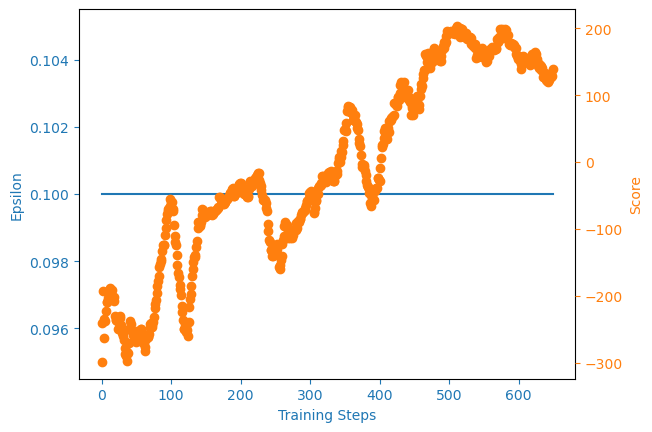

In [57]:
# in cer paper, they did'nt used decaying epsilon greedy.
import gymnasium as gym
import time
import signal
import time
import sys
import pickle

env = make_env("LunarLander-v2", "videos/", 50)
action_space = [_ for _ in range(env.action_space.n)]
record = True


trainer_params = {
    "noe": 650, 
    "max_steps": 10000,
    "max_eps": 0.1,
    "min_eps": 0.1,
    "eps_decay_rate": 1e-5,
    "eps": 0.1,
    "action_space": action_space,
    "is_tg": True,
    "tg_bot_freq_epi": 10,
    "record": record,
    "gamma": 0.99, 
    "lr": 0.0001, 
    "input_dims": env.observation_space.shape,
    "mem_size" : 30000,
    "batch_size" : 32,
    "replace" : 1000,
    "algo" : "DQN",
    "env_name" : "lunarlander",
    "n_actions" : len(action_space),
    "chkpt_dir": "tmp/dqn/",
    "actions": action_space,
    "target_score": 230,
    "tau": 0.01,
    "target_update": 230,
    "cer": True
}

    
if __name__ == "__main__": 
    
    try: 
        manage_memory()
       
        trainer = Trainer(env, trainer_params)
        episode_rewards, epsilon_history, avg_rewards, best_reward = trainer.train_rl_model()
        
        with open("dqn_episode_rewards.obj", "wb") as f: 
            pickle.dump(episode_rewards, f)
        
        with open("dqn_epsilon_history.obj", "wb") as f: 
            pickle.dump(epsilon_history, f)
        
        with open("dqn_avg_rewards.obj", "wb") as f: 
            pickle.dump(avg_rewards, f)
            
        plot_learning_curve(episode_rewards, epsilon_history, "vanila_dqn_cer")
        
    except Exception as error: 
        raise error
        
   # eval_model(env, "keras model", "videos/", fps=10)


In [59]:
import gymnasium as gym
import time

env = make_env("LunarLander-v2", "videos/", 50)
action_space = [_ for _ in range(env.action_space.n)]

import random 
import imageio

def eval_model(env, model, out_directory, fps=20):
    images = []  
    done = False
    state = env.reset(seed=random.randint(0,500))
    img = env.render()
    images.append(img)
    rewards = 0 
    while not done:
        if type(state) == tuple: 
            state = state[0].astype("float32")
        action = greedy_policy(state, model, action_space)
        state, reward, done, info, _ = env.step(action) 
        rewards += reward
        
        img = env.render()
        images.append(img)
    imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)
    return rewards

In [66]:
model = tf.keras.models.load_model("/kaggle/working/tmp/dqn/lunarlander_DQN_q_value_cer")
rewards = eval_model(env, model, "video.mp4", fps=30)
rewards

[swscaler @ 0x640c200] Warning: data is not aligned! This can lead to a speed loss


114.46160243925621